## Inititalize

In [4]:
!pip install --upgrade pip
!pip uninstall -y enum34
!pip install --upgrade pyproj pandas shapely geopandas dask_ml joblib scikit-learn==0.22.2.post1 dask[dataframe]==2.12.0 distributed==2.12.0 lz4==3.0.2 blosc==1.8.3 cloudpickle==1.3.0 msgpack==1.0.0 numpy==1.18.1 toolz==0.10.0 tornado==6.0.4 imbalanced-learn

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.0.2)
  Using cached pyproj-2.6.0-cp36-cp36m-manylinux2010_x86_64.whl (10.4 MB)
  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached Shapely-1.7.0-cp36-cp36m-manylinux1_x86_64.whl (1.8 MB)
  Using cached geopandas-0.7.0-py2.py3-none-any.whl (928 kB)
  Using cached dask_ml-1.2.0-py3-none-any.whl (124 kB)
  Using cached joblib-0.14.1-py2.py3-none-any.whl (294 kB)
  Using cached scikit_learn-0.22.2.post1-cp36-cp36m-manylinux1_x86_64.whl (7.1 MB)
  Using cached dask-2.12.0-py3-none-any.whl (789 kB)
  Using cached distributed-2.12.0-py3-none-any.whl (601 kB)
  Using cached lz4-3.0.2-cp36-cp36m-manylinux2010_x86_64.whl (1.8 MB)
  Using cached blosc-1.8.3.tar.gz (809 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 274 kB 11.3 MB/s eta

In [2]:
!pip install --upgrade keras==2.1.5 tensorflow==2.0

     |████████████████████████████████| 334 kB 20.4 MB/s eta 0:00:0101
  Using cached tensorflow-2.0.0-cp36-cp36m-manylinux2010_x86_64.whl (86.3 MB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached tensorflow_estimator-2.0.1-py2.py3-none-any.whl (449 kB)
Processing /home/ec2-user/.cache/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63/wrapt-1.12.1-cp36-cp36m-linux_x86_64.whl
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.0
    Uninstalling Keras-2.3.0:
      Successfully uninstalled Keras-2.3.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.10.11
ERROR: Cannot uninstall 'wrapt'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which wo

General

In [21]:
import pandas as pd
import numpy as np
from dask.distributed import Client, as_completed
from dask import delayed
import dask.dataframe as dd
import dask, ast, itertools
import dask_ml.model_selection as dcv

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
import datetime as dt
import boto3, yaml
from sagemaker import get_execution_role
from datetime import timedelta

from scipy.stats import expon

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
import itertools
from sklearn.metrics import roc_curve, auc, precision_score, f1_score, recall_score, average_precision_score, precision_recall_curve, confusion_matrix

import sys,os, joblib
util_path = os.path.abspath(os.path.join(os.path.pardir, '../sasse-polygon-process/lib'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)
    
from util import evaluate, feature_selection
from config import read_options
from viz import Viz
from filehandler import FileHandler

sns.set()
sns.set_style("whitegrid")
%matplotlib inline

MLP

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping
import platform
import glob

VAE

In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Following snippet is used to get forest columns from database (inserted into ../cnf/rfc.ini)

In [10]:
data = pd.read_csv('../data/classification_dataset_loiste_jse_forest.csv')
for c in data.columns:    
    if 'Forest' in c:
        print(c, end=',')

mean Forest age,max Forest age,std Forest age,mean Forest site fertility,max Forest site fertility,std Forest site fertility,mean Forest stand mean diameter,max Forest stand mean diameter,std Forest stand mean diameter,mean Forest stand mean height,max Forest stand mean height,std Forest stand mean height,mean Forest canopy cover,max Forest canopy cover,std Forest canopy cover,mean Forest site main class,max Forest site main class,std Forest site main class,

In [3]:
print(dask.__version__)
print(pd.__version__)

2.12.0
1.0.3


In [34]:
client = Client('Dask-Scheduler.local-dask:8786')
client.get_versions(check=True)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.77 GB


In [ ]:
client.restart()

In [5]:
fh = FileHandler() #s3_bucket='fmi-sasse-classification-dataset')
viz = Viz()

In [6]:
class Options(): pass

options = Options()
options.config_filename = '../cnf/rfc.ini'
options.config_name = 'forest'
read_options(options)

options_thin = Options()
options_thin.config_filename = '../cnf/rfc.ini'
options_thin.config_name = 'thin'
read_options(options_thin)

## Functions

Needed to visualise trained models later:

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.YlOrBr,
                          filename=None,
                          fontsize=20):
        """
        Normalization can be applied by setting `normalize=True`.
        """
        plt.clf()
        plt.rc('font', size=fontsize)

        fig, ax = plt.subplots(figsize=(6,6))
        np.set_printoptions(precision=2)
        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.grid(False, which='major')
        
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        tick_marks = np.arange(len(classes))
        ax.xaxis.tick_top()
        plt.xticks(tick_marks, classes) #, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        fig.subplots_adjust(bottom=0.12)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [8]:
def prec_rec_curve(y, y_pred, n_classes, fontsize=20):
    """
    Precision - Recall Curve
    """
    plt.rc('font', size=fontsize)

    y = label_binarize(y, classes=np.arange(n_classes))

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y[:, i], y_pred[:, i])
        average_precision[i] = average_precision_score(y[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(), y_pred.ravel())
    average_precision["micro"] = average_precision_score(y, y_pred, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

    plt.figure(figsize=(12, 12))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y_ = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y_ >= 0], y_[y_ >= 0], color='gray', alpha=0.5)
        plt.annotate('F1={0:0.1f}'.format(f_score), xy=(0.9, y_[45] + 0.02))

    lines.append(l)
    labels.append('F1 curves')

    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('Micro-average (area = {0:0.2f})'
    ''.format(average_precision["micro"]))

    for i in range(n_classes):
        l, = plt.plot(recall[i], precision[i], lw=2)
        lines.append(l)
        labels.append('Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(np.arange(.2, 1., .2))
    plt.xlabel('Recall', labelpad=20)
    plt.ylabel('Precision', labelpad=20)
    plt.title('Precision-Recall Curve', pad=20)
    plt.legend(lines, labels, loc=(0, -.2), ncol=2)

In [9]:
def feature_importance(data, feature_names = None, fontsize=20):
    """ Plot feature importance """

    fig, ax = plt.subplots(figsize=(24,18))

    plt.clf()
    plt.rc('font', size=fontsize)

    if feature_names is None:
        feature_names = range(0,len(data))
    else:
        plt.xticks(rotation=90, fontsize=fontsize)
        fig.subplots_adjust(bottom=0.5)

    plt.yticks(fontsize=fontsize*2/3)
    plt.bar(feature_names, data, align='center')
    plt.xlabel('Components', fontsize=fontsize, labelpad=20)
    plt.ylabel('Importance', fontsize=fontsize, labelpad=20)
    
    #ax.tick_params(axis='both', which='major', labelsize=fontsize)
    #ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # plt.tight_layout()
    #fig.subplots_adjust(bottom=0.5)

    #self._save(plt, filename)

In [10]:
def cv(model, param_grid, X, y, n_iter=20): 
    cv_results = None
    print('..performing cv search...')
    searches = []

    # Define jobs
    random_search = dcv.RandomizedSearchCV(model, 
                                           param_grid, 
                                           n_iter=n_iter,
                                           scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                           return_train_score=True,
                                           refit=False).fit(X, y)
    # Gather results
    cv_results = pd.DataFrame(random_search.cv_results_) #.head(1)    
    cv_results.sort_values(by=['mean_test_f1_macro'], inplace=True, ascending=False, ignore_index=True)
    print(cv_results.head())
    
    best_params = cv_results.loc[0,'params']
    model = model.set_params(**best_params)

    print('Using configuration: {}'.format(best_params))

    with joblib.parallel_backend('dask'):
        model.fit(X, y)
        
    return model, cv_results

In [66]:
def plot_class_hist(data_train, data_test, num_classes=4, fontsize=10):
    fig, ax = plt.subplots(figsize=(15,5))

    plt.rc('font', size=fontsize)
    ax = plt.subplot(1,2,1)
    
    if not isinstance(data_train, pd.DataFrame):
        data_train = pd.DataFrame(data_train, columns=['class'])
    if not isinstance(data_test, pd.DataFrame):
        data_test = pd.DataFrame(data_test, columns=['class'])
        
    data_train.loc[:, 'class'].hist(ax=ax)
    plt.title('Train set')
    plt.ylabel('Record count')
    plt.xlabel('Class')

    i=0
    for rect in ax.patches:
        if i%(num_classes-1) == 0:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                        xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
        i+=1
    
    ax = plt.subplot(1,2,2)
    data_test.loc[:, 'class'].hist(ax=ax)    
    plt.title('Test set')
    plt.ylabel('Record count')
    plt.xlabel('Class')
    
    i=0
    for rect in ax.patches:
        if i%(num_classes-1) == 0:
            height = rect.get_height()
            ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                        xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 
        i+=1

## Loiste-JSE

### Select data

In [117]:
def get_data(name, options, size=None, balance=False, cherry_pick=None, max_size=None):
    """ Read and normalise data """
    
    data = pd.read_csv(name)
    data = data.loc[data['weather_parameter'] == 'WindGust'].fillna(0)

    label = options.label[0]
    
    if size is None:
        y = data.loc[:, options.label].values.ravel()
        data_train, data_test, _, __ = train_test_split(data, y, stratify=y)        
    else:   
        
#        if balance:
            
#            count = data.groupby(label).size().min()
#            data = pd.concat([data.loc[data[label] == 0].sample(n=count), data.loc[data[label] == 1].sample(n=count)])

        if cherry_pick is not None and size[0] < 1 and size[1] < 1:
            # Classes which are not cherry-picked
            classes = list(data.loc[:, label].unique())
            not_cherry_picked = list(set(classes) - set(cherry_pick))
            random_data = data.loc[data.loc[:,label].isin(not_cherry_picked),:]
            random_y = random_data.loc[:, label].values.ravel()
            data_train, data_test, _, __ = train_test_split(random_data, random_y, train_size=size[0], test_size=size[1], stratify=random_y)

            # Cherry picked classes
            picked_data = data.loc[data.loc[:,label].isin(classes),:]
            picked_data_train, picked_data_test = train_test_split(picked_data, train_size=size[0], test_size=size[1])
            
            # Concat
            data_train = pd.concat([data_train, picked_data_train])
            data_test = pd.concat([data_test, picked_data_test])                        
        else:            
            y = data.loc[:, options.label].values.ravel()        
            data_train, data_test, _, __ = train_test_split(data, y, train_size=size[0], test_size=size[1], stratify=y)

            
    # Cut all classes to max size
    if max_size is not None:
        dfs = []
        for c in list(data_train.loc[:, label].unique()):
            dfs.append(data_train.loc[(data[label] == c),:].reset_index(drop=True).iloc[0:max_size,:])
        data_train = pd.concat(dfs)
            
    #data_train, data_test, _, __ = train_test_split(data, y, train_size=.7, test_size=.3, stratify=y)        
    #data_train, data_test = train_test_split(data)

    X_train = data_train.loc[:, options.feature_params]
    y_train = data_train.loc[:, options.label].values.ravel()

    X_test = data_test.loc[:, options.feature_params]
    y_test = data_test.loc[:, options.label].values.ravel()
    
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=options.feature_params)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=options.feature_params)
    
    try:
        sm = SMOTE()
        X_res, y_res = sm.fit_resample(X_train, y_train)
    except: 
        X_res, y_res = None, None
    
    return X_train, y_train, X_res, y_res, X_test, y_test

In [13]:
X_train, y_train, X_res, y_res, X_test, y_test = get_data('../data/classification_dataset_loiste_jse_forest.csv', options)
X_train_thin, y_train_thin, X_res_thin, y_res_thin, X_test_thin, y_test_thin = get_data('../data/classification_dataset_loiste_jse_forest.csv', options_thin)

#### Visualise

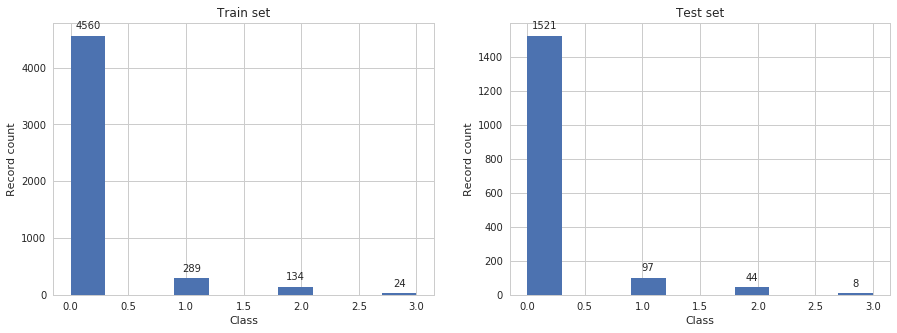

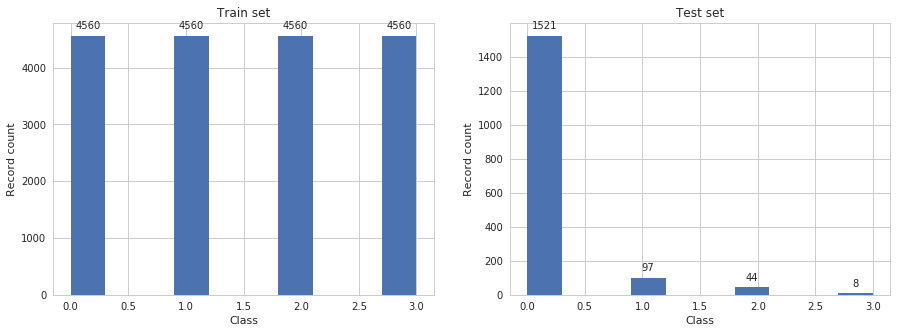

In [70]:
plot_class_hist(y_train, y_test)
plot_class_hist(y_res, y_test)

### RFC

#### All features

In [325]:
model = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

with joblib.parallel_backend('dask'):
    model.fit(X_train, y_train)

Visualise trained model performance

<Figure size 432x288 with 0 Axes>

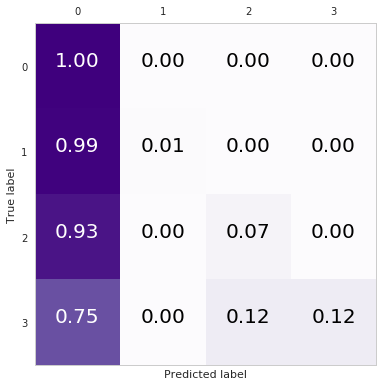

In [326]:
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

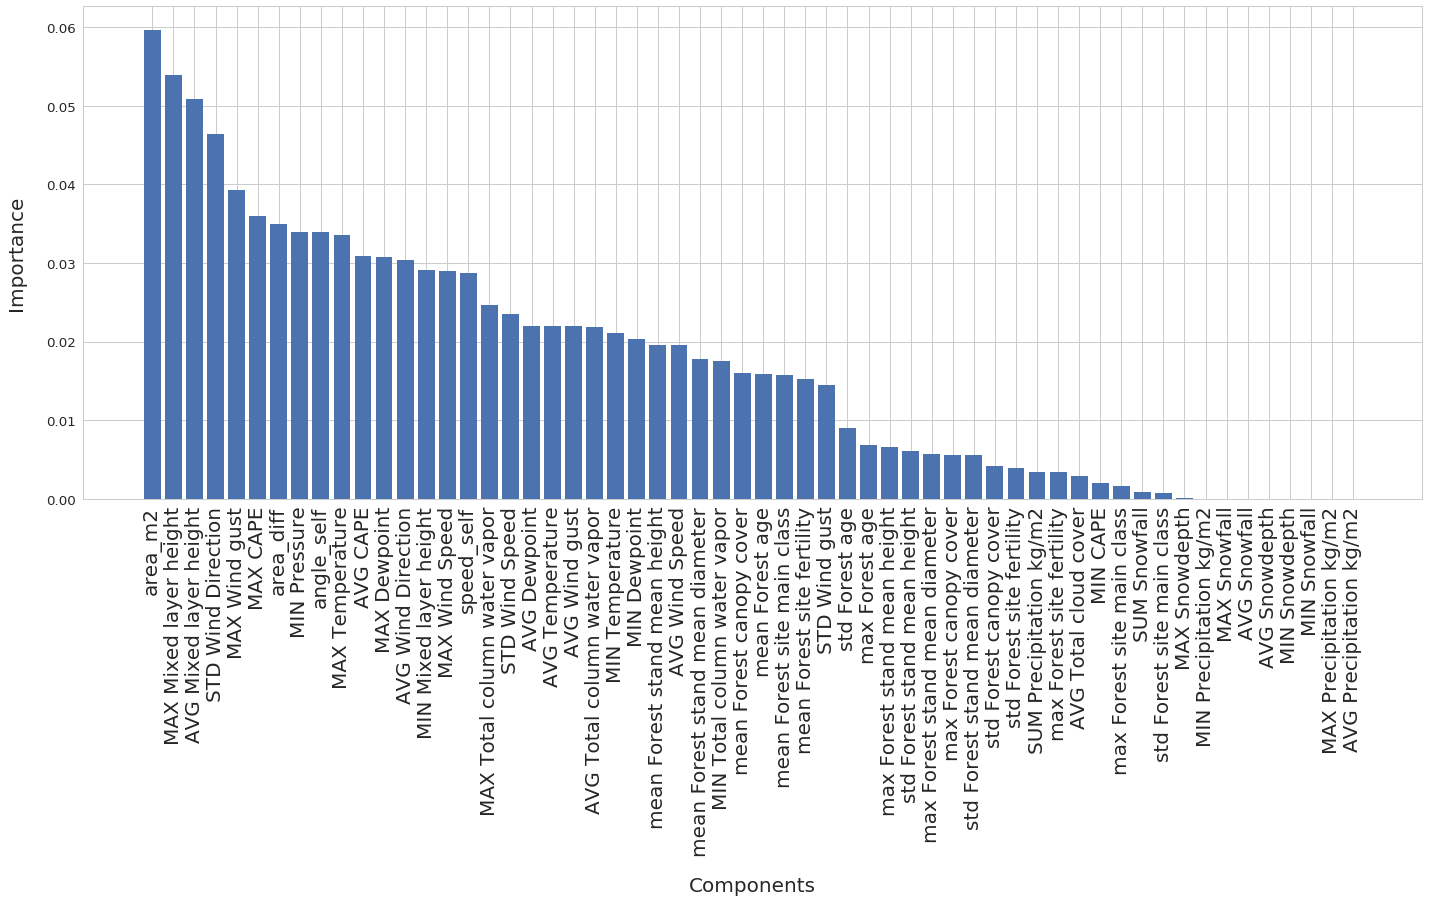

In [327]:
# Sort feature importances in descending order and rearrange feature names accordingly
indices = np.argsort(model.feature_importances_)[::-1]
names = [options.feature_params[i] for i in indices]
importances = model.feature_importances_[indices]
feature_importance(importances, names)

Some notes: 
1. The only precipitation feature is SUM precipitation kg/m2, which also have very little importance. 
2. Only mean aggregations of forest parameters are important

#### SMOTE

In [35]:
model_res = RandomForestClassifier(n_jobs=-1)

with joblib.parallel_backend('dask'):
    model_res.fit(X_res, y_res)

# Sort feature importances in descending order and rearrange feature names accordingly
indices_res = np.argsort(model_res.feature_importances_)[::1]
names_res = [options.feature_params[i] for i in indices_res]

<Figure size 432x288 with 0 Axes>

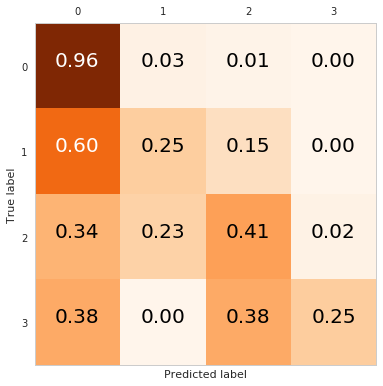

In [36]:
y_pred_res = model_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred_res, range(0,4), normalize=True, cmap=plt.cm.Oranges)

#### Randomised CV search for RFC

In [16]:
class_weights = []
for i in np.arange(0,1,.1):
    for j in np.arange(0, 1-i, .1):
        for k in np.arange(0,1-i-j, .1):
            l = 1 - i - j -k
            class_weights.append({0: i, 1: j, 2: k, 3: l})

param_grid_rfc = {"n_estimators": [10, 100, 150, 200, 250, 500, 800],
                  "max_depth": [3, 10, 20, 50, None],
                  "max_features": ["auto", "sqrt", "log2", None],
                  "min_samples_split": [2,5,10,50],
                  "min_samples_leaf": [1, 2, 4, 10, 20],
                  "bootstrap": [True, False],
                  "class_weight": class_weights}

In [17]:
model_res = RandomForestClassifier(n_jobs=-1)
model_res, cv_results = cv(model_res, param_grid_rfc, X_res, y_res, n_iter=50)
y_pred_res = model_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred_res, range(0,4), normalize=True, cmap=plt.cm.Oranges)

..performing cv search...
                                              params  mean_fit_time  \
0  {'n_estimators': 250, 'min_samples_split': 5, ...      25.555062   
1  {'n_estimators': 500, 'min_samples_split': 5, ...      74.203605   
2  {'n_estimators': 500, 'min_samples_split': 10,...      48.698317   
3  {'n_estimators': 800, 'min_samples_split': 10,...      73.736697   
4  {'n_estimators': 10, 'min_samples_split': 10, ...       2.429622   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      1.662311         3.460093        0.223335              0.973632   
1      0.288396         6.638059        1.464270              0.973761   
2      3.533546         7.123029        0.200622              0.966334   
3     19.749531         5.120491        3.388634              0.965992   
4      0.049769         0.165000        0.037233              0.962987   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.978218          

AttributeError: 'tuple' object has no attribute 'predict'

<Figure size 432x288 with 0 Axes>

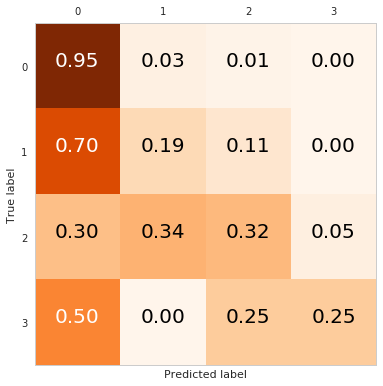

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [18]:
y_pred_res = model_res[0].predict(X_test)
plot_confusion_matrix(y_test, y_pred_res, range(0,4), normalize=True, cmap=plt.cm.Oranges)

#### Thin setup (few parameters)

..performing cv search...
                                              params  mean_fit_time  \
0  {'n_estimators': 150, 'min_samples_split': 5, ...       5.369146   
1  {'n_estimators': 150, 'min_samples_split': 10,...       3.707161   
2  {'n_estimators': 10, 'min_samples_split': 2, '...       0.310732   
3  {'n_estimators': 250, 'min_samples_split': 5, ...      23.734615   
4  {'n_estimators': 200, 'min_samples_split': 5, ...      12.686347   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.262964         0.412179        0.073978              0.331203   
1      0.200687         0.629193        0.038753              0.263880   
2      0.076347         0.069061        0.026463              0.278141   
3      4.494200         0.484058        0.207652              0.253599   
4      1.452828         0.185883        0.003042              0.243173   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.413179          

<Figure size 432x288 with 0 Axes>

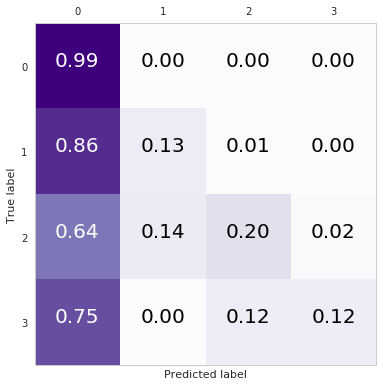

In [354]:
model_rfc_thin = RandomForestClassifier(n_jobs=-1)
model_rfc_thin, cv_results = cv(model_rfc_thin, param_grid_rfc, X_train_thin, y_train_thin)
y_pred_rfc_thin = model_rfc_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred_rfc_thin, range(0,4), normalize=True, cmap=plt.cm.Purples)

#### Thin setup (few parameters) with SMOTE

..performing cv search...
                                              params  mean_fit_time  \
0  {'n_estimators': 800, 'min_samples_split': 10,...     108.797124   
1  {'n_estimators': 800, 'min_samples_split': 10,...     134.606404   
2  {'n_estimators': 10, 'min_samples_split': 10, ...       2.359201   
3  {'n_estimators': 10, 'min_samples_split': 2, '...       1.533115   
4  {'n_estimators': 100, 'min_samples_split': 50,...      19.255034   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      5.847979         2.768994        0.065169              0.980900   
1     17.888930         4.149653        2.019232              0.973784   
2      0.047671         0.169261        0.034627              0.961940   
3      0.038425         0.222678        0.027980              0.961053   
4      2.480750         0.957167        0.459804              0.952554   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.982960          

<Figure size 432x288 with 0 Axes>

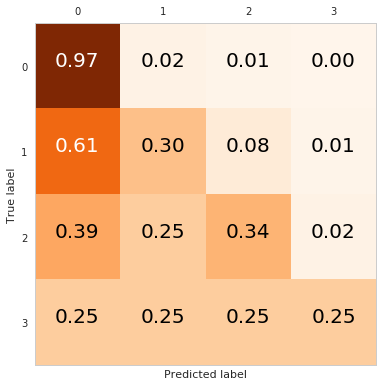

In [355]:
model_res_thin = RandomForestClassifier(n_jobs=-1)
model_res_thin, cv_results = cv(model_res_thin, param_grid_rfc, X_res_thin, y_res_thin)
y_pred_res_thin = model_res_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred_res_thin, range(0,4), normalize=True, cmap=plt.cm.Oranges)

### SVC

#### Train model with all features

In [45]:
model_svc = SVC(class_weight="balanced")

with joblib.parallel_backend('dask'):
    model_svc.fit(X_train, y_train)

Visualise trained model performance

<Figure size 432x288 with 0 Axes>

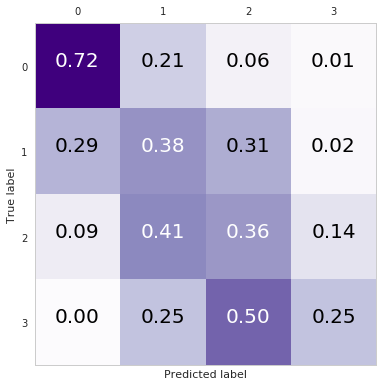

In [46]:
y_pred_svc = model_svc.predict(X_test)
plot_confusion_matrix(y_test, y_pred_svc, range(0,4), normalize=True, cmap=plt.cm.Purples)

#### Train with SMOTE

<Figure size 432x288 with 0 Axes>

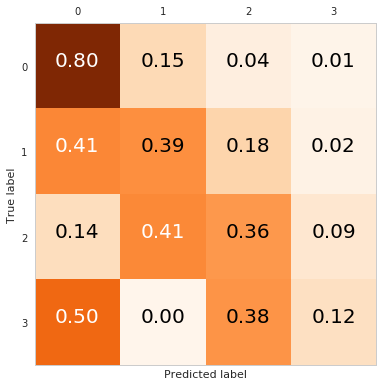

In [47]:
model_svc_res = SVC()

with joblib.parallel_backend('dask'):
    model_svc_res.fit(X_res, y_res)
    
y_pred = model_svc_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Oranges)

#### Random Search CV for SVC

In [ ]:
param_grid = {'C': expon(scale=100), 
              'gamma': expon(scale=.1),
              'kernel':  ['linear', 'rbf', 'sigmoid'],
              'coef0': expon(scale=1)
             }

random_search = dcv.RandomizedSearchCV(SVC(), 
                                       param_grid, 
                                       n_iter=10,
                                       #scoring=['f1_macro', 'f1_micro', 'accuracy'],
                                       return_train_score=True,
                                       refit=False)
random_search.fit(X_res, y_res)
cv_results_svc = pd.DataFrame(random_search.cv_results_)
cv_results_svc.head()

In [23]:
# Save and visualise results
fname = 'results/random_search_cv_svc_results.csv'.format(options.output_path)
fh.df_to_csv(cv_results_svc, fname, fname)

In [58]:
#best_params = ast.literal_eval(cv_results.loc[0,'params'])
best_params = cv_results_svc.loc[0,'params']
model = SVC(**best_params)
print('Using configuration: {}'.format(best_params))

with joblib.parallel_backend('dask'):
    model.fit(X_res, y_res)

Using configuration: {'C': 43.00941859880199, 'coef0': 0.6185130177472298, 'gamma': 0.04340235910077486, 'kernel': 'sigmoid'}


<Figure size 432x288 with 0 Axes>

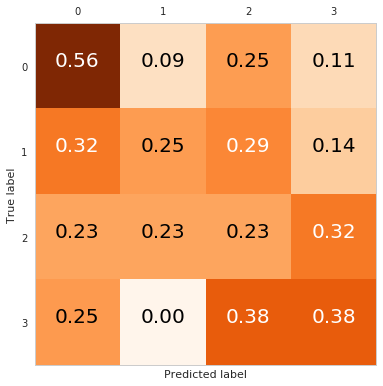

In [59]:
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Oranges)

### GaussianNB

#### All features

<Figure size 432x288 with 0 Axes>

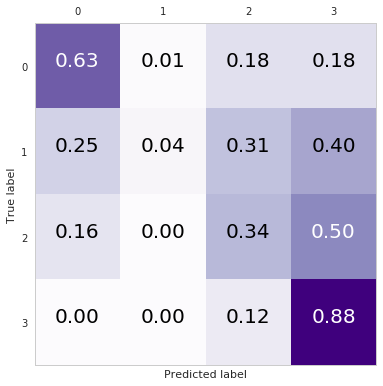

In [183]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

In [186]:
print(gnb.class_prior_)

[0.91 0.06 0.03 0.  ]


#### Random search CV for priors

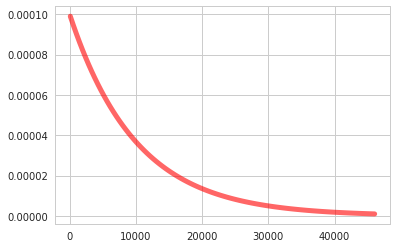

In [233]:
from scipy.stats import expon
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
scale=10000
x = np.linspace(expon.ppf(0.01, scale=scale),
                 expon.ppf(0.99, scale=scale), 100)
ax.plot(x, expon.pdf(x, scale=scale),
        'r-', lw=5, alpha=0.6, label='expon pdf')

In [357]:
priors = []
for i in np.arange(0,1,.05):
    for j in np.arange(0, 1-i, .05):
        for k in np.arange(0,1-i-j, .05):
            l = 1 - i - j -k
            priors.append([i, j, k, l])
                            
param_grid_gnb = {'priors': priors+[None],
                  'var_smoothing': expon(scale=.01)}
#param_grid = {'priors': [None]}

##### All parameters

..performing cv search...
                                              params  mean_fit_time  \
0  {'priors': [0.45, 0.30000000000000004, 0.2, 0....       0.005262   
1  {'priors': [0.30000000000000004, 0.60000000000...       0.004785   
2  {'priors': [0.25, 0.30000000000000004, 0.4, 0....       0.005701   
3  {'priors': [0.5, 0.25, 0.15000000000000002, 0....       0.004975   
4  {'priors': [0.4, 0.15000000000000002, 0.350000...       0.004460   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.000391         0.012822        0.000485              0.280165   
1      0.000534         0.013089        0.001104              0.279934   
2      0.002176         0.013745        0.001546              0.289721   
3      0.000322         0.012379        0.000345              0.286583   
4      0.000513         0.012485        0.000449              0.289637   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.268751          

<Figure size 432x288 with 0 Axes>

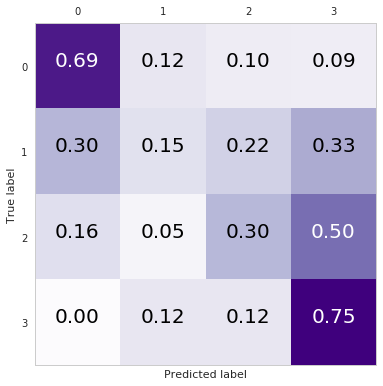

In [295]:
gnb_priors = GaussianNB()
gnb_priors, cv_results = cv(gnb_priors, param_grid_gnb, X_train, y_train, 100)
y_pred = gnb_priors.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.74


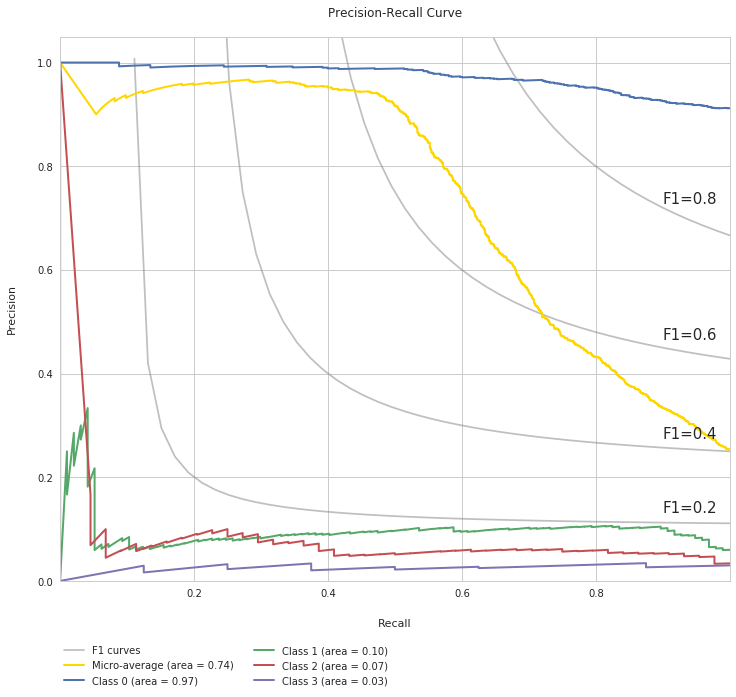

In [296]:
prec_rec_curve(y_test, gnb_priors.predict_proba(X_test), 4, fontsize=15)

##### Thin setup

..performing cv search...
                                              params  mean_fit_time  \
0  {'priors': [0.45, 0.15000000000000002, 0.35000...       0.008357   
1  {'priors': [0.45, 0.45, 0.1, 2.775557561562891...       0.007852   
2  {'priors': [0.30000000000000004, 0.55, 0.05, 0...       0.009196   
3  {'priors': [0.4, 0.30000000000000004, 0.150000...       0.007399   
4  {'priors': [0.45, 0.25, 0.2, 0.100000000000000...       0.005396   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.001375         0.048585        0.019347              0.325946   
1      0.001593         0.034435        0.017420              0.283139   
2      0.001694         0.022513        0.000895              0.311999   
3      0.000044         0.047432        0.020131              0.302236   
4      0.001832         0.030929        0.016026              0.306129   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.278817          

<Figure size 432x288 with 0 Axes>

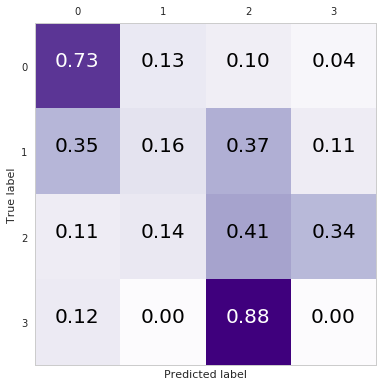

In [358]:
gnb_priors_thin = GaussianNB()
gnb_priors_thin, cv_results = cv(gnb_priors, param_grid_gnb, X_train_thin, y_train_thin, 100)
y_pred = gnb_priors_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred, range(0,4), normalize=True, cmap=plt.cm.Purples)

##### SMOTE

..performing cv search...
                                              params  mean_fit_time  \
0  {'priors': [0.2, 0.5, 0.2, 0.10000000000000003...       0.043734   
1  {'priors': [0.25, 0.25, 0.45, 0.04999999999999...       0.031832   
2  {'priors': [0.05, 0.5, 0.25, 0.199999999999999...       0.033079   
3  {'priors': [0.4, 0.30000000000000004, 0.25, 0....       0.032973   
4  {'priors': [0.25, 0.2, 0.5, 0.0500000000000000...       0.030259   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.020325         0.076422        0.020872              0.464581   
1      0.016691         0.094235        0.004293              0.461651   
2      0.024814         0.091784        0.005421              0.463830   
3      0.023621         0.094687        0.001221              0.461024   
4      0.021464         0.095769        0.002413              0.459291   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.471138          

<Figure size 432x288 with 0 Axes>

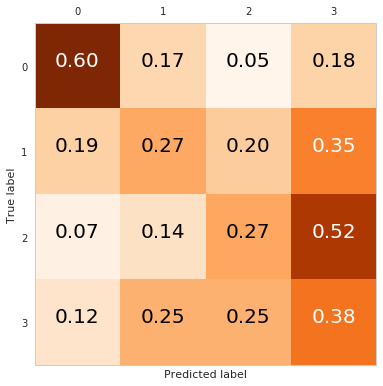

In [359]:
gnb_priors_res = GaussianNB()
gnb_priors_res, cv_results = cv(gnb_priors, param_grid_gnb, X_res, y_res, 50)
y_pred = gnb_priors_res.predict(X_test)
plot_confusion_matrix(y_test, y_pred, range(0,4), normalize=True, cmap=plt.cm.Oranges)

##### Thin smote

..performing cv search...
                                              params  mean_fit_time  \
0  {'priors': [0.05, 0.1, 0.75, 0.099999999999999...       0.024158   
1  {'priors': [0.4, 0.30000000000000004, 0.25, 0....       0.012026   
2  {'priors': [0.05, 0.45, 0.2, 0.299999999999999...       0.014614   
3  {'priors': [0.15000000000000002, 0.65, 0.1, 0....       0.026401   
4  {'priors': [0.1, 0.45, 0.2, 0.25], 'var_smooth...       0.026413   

   std_fit_time  mean_score_time  std_score_time  split0_test_f1_macro  \
0      0.006644         0.060830        0.032804              0.499308   
1      0.000352         0.047832        0.015967              0.488715   
2      0.002369         0.062221        0.022472              0.492158   
3      0.022000         0.060536        0.019815              0.485822   
4      0.021892         0.066481        0.022902              0.488519   

   split1_test_f1_macro  split2_test_f1_macro  mean_test_f1_macro  \
0              0.511958          

<Figure size 432x288 with 0 Axes>

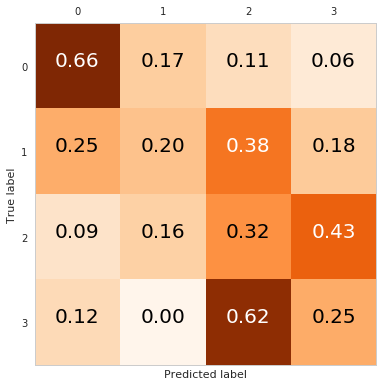

In [360]:
gnb_res_thin = GaussianNB()
gnb_res_thin, cv_results = cv(gnb_res_thin, param_grid_gnb, X_res_thin, y_res_thin, 40)
y_pred_res_thin = gnb_res_thin.predict(X_test_thin)
plot_confusion_matrix(y_test_thin, y_pred_res_thin, range(0,4), normalize=True, cmap=plt.cm.Oranges)

#### With PCA 

With all features in PCA:

<Figure size 432x288 with 0 Axes>

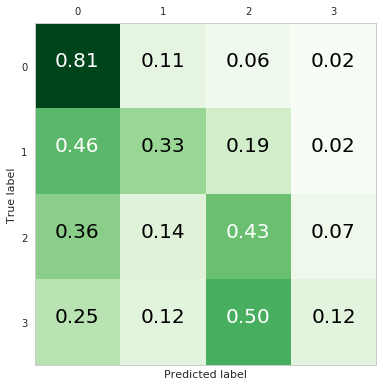

In [271]:
gnb_pca = make_pipeline(PCA(n_components=50), GaussianNB())
gnb_pca.fit(X_train, y_train)
y_pred_gnb_pca = gnb_pca.predict(X_test)
plot_confusion_matrix(y_test, y_pred_gnb_pca, range(0,4), normalize=True, cmap=plt.cm.Greens)

With 15 features in PCA (spoiler alert, using less features makes model to predict always class 0):

<Figure size 432x288 with 0 Axes>

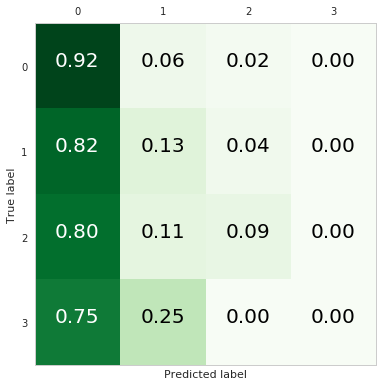

In [272]:
gnb_pca = make_pipeline(PCA(n_components=15), GaussianNB())
gnb_pca.fit(X_train, y_train)
y_pred_gnb_pca = gnb_pca.predict(X_test)
plot_confusion_matrix(y_test, y_pred_gnb_pca, range(0,4), normalize=True, cmap=plt.cm.Greens)

#### MLP

In [122]:
# Define a trained and saved model
def train_model(X_train, y_train, X_test, y_test):
    batch_size = 512
    num_classes = 4
    epochs = 500
    dropout_rate = .1    
    
    class_weight = {0: .1,
                    1: .5,
                    2: 1.,
                    3: 1000.}
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(dropout_rate))    
    model.add(Dense(8, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, y_test),
              callbacks=[es],
              class_weight=class_weight)
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model

In [123]:
mlp = train_model(X_res.values, y_res, X_test.values, y_test)

Train on 18240 samples, validate on 1670 samples
Epoch 1/500
18240/18240 [==============================] - 2s 135us/step - loss: 38.8540 - acc: 0.2525 - val_loss: 5.6038 - val_acc: 0.0048
Epoch 2/500
18240/18240 [==============================] - 1s 60us/step - loss: 3.4700 - acc: 0.2741 - val_loss: 3.9869 - val_acc: 0.0120
Epoch 3/500
18240/18240 [==============================] - 1s 60us/step - loss: 2.1478 - acc: 0.3583 - val_loss: 3.5750 - val_acc: 0.0204
Epoch 4/500
18240/18240 [==============================] - 1s 61us/step - loss: 1.3456 - acc: 0.4209 - val_loss: 3.2041 - val_acc: 0.0198
Epoch 5/500
18240/18240 [==============================] - 1s 61us/step - loss: 1.1071 - acc: 0.4538 - val_loss: 3.0137 - val_acc: 0.0210
Epoch 6/500
18240/18240 [==============================] - 1s 60us/step - loss: 0.7329 - acc: 0.4840 - val_loss: 2.7411 - val_acc: 0.0293
Epoch 7/500
18240/18240 [==============================] - 1s 60us/step - loss: 0.6660 - acc: 0.5015 - val_loss: 2.4552 -

In [ ]:
#local_client = Client()
with joblib.parallel_backend('dask'):
    mlp = train_model(X_train.values, y_train, X_test.values, y_test)

<Figure size 432x288 with 0 Axes>

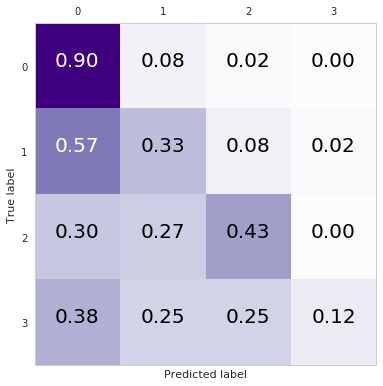

In [124]:
y_pred_mlp_proba = mlp.predict_proba(X_test.values)
y_pred_mlp = np.argmax(y_pred_mlp_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_mlp, range(0,4), normalize=True, cmap=plt.cm.Purples)

#### Gaussian Processes

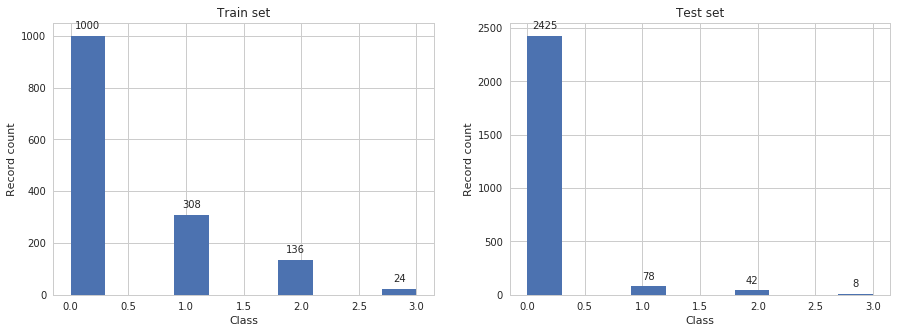

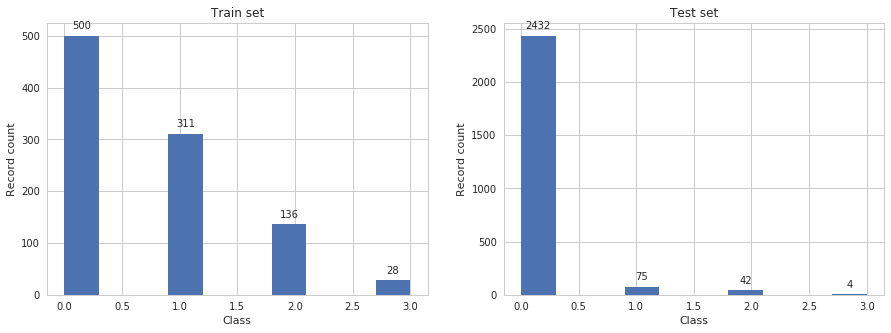

In [134]:
X_train_small, y_train_small, X_res_small, y_res_small, X_test_small, y_test_small = get_data('../data/classification_dataset_loiste_jse_forest.csv', options, (.8, .2), cherry_pick=[1,2,3], max_size=1000)
plot_class_hist(y_train_small, y_test_small)

X_train_tiny, y_train_tiny, X_res_tiny, y_res_tiny, X_test_tiny, y_test_tiny = get_data('../data/classification_dataset_loiste_jse_forest.csv', options, (.8, .2), cherry_pick=[1,2,3], max_size=500)
plot_class_hist(y_train_tiny, y_test_tiny)

In [36]:
client.restart()

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 3 Cores: 6 Memory: 25.77 GB


##### Pairwise kernel

In [120]:
#kernel = 1.0 * RBF(1.0)
from sklearn.gaussian_process.kernels import PairwiseKernel
kernel = PairwiseKernel()
gpc = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc.fit(X_train, y_train)

<Figure size 432x288 with 0 Axes>

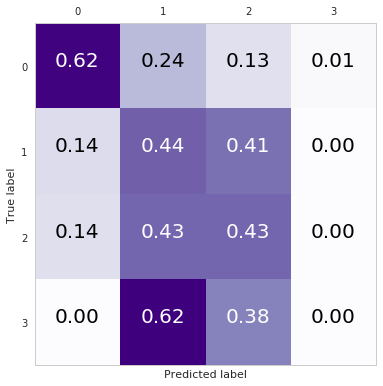

In [121]:
y_pred_gpc_proba = gpc.predict_proba(X_test.values)
y_pred_gpc = np.argmax(y_pred_gpc_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc, range(0,4), normalize=True, cmap=plt.cm.Purples)

##### Dotproduct kernel

In [123]:
#kernel = 1.0 * RBF(1.0)
from sklearn.gaussian_process.kernels import DotProduct
kernel = DotProduct()
gpc = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc.fit(X_train, y_train)

<Figure size 432x288 with 0 Axes>

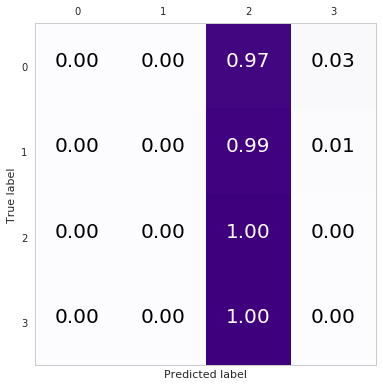

In [124]:
y_pred_gpc_proba = gpc.predict_proba(X_test.values)
y_pred_gpc = np.argmax(y_pred_gpc_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc, range(0,4), normalize=True, cmap=plt.cm.Purples)

##### Compound kernel

In [137]:
from sklearn.gaussian_process.kernels import CompoundKernel

kernel = PairwiseKernel() *  DotProduct()
gpc = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc.fit(X_train_small, y_train_small)

<Figure size 432x288 with 0 Axes>

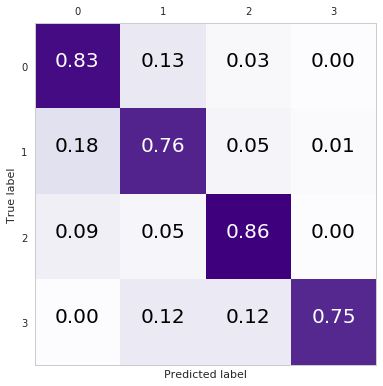

In [140]:
y_pred_gpc_proba = gpc.predict_proba(X_test.values)
y_pred_gpc = np.argmax(y_pred_gpc_proba, axis=1)
#y_pred_gpc = gpc.predict(X_test.values)
plot_confusion_matrix(y_test, y_pred_gpc, range(0,4), normalize=True, cmap=plt.cm.Purples)

Average precision score, micro-averaged over all classes: 0.89


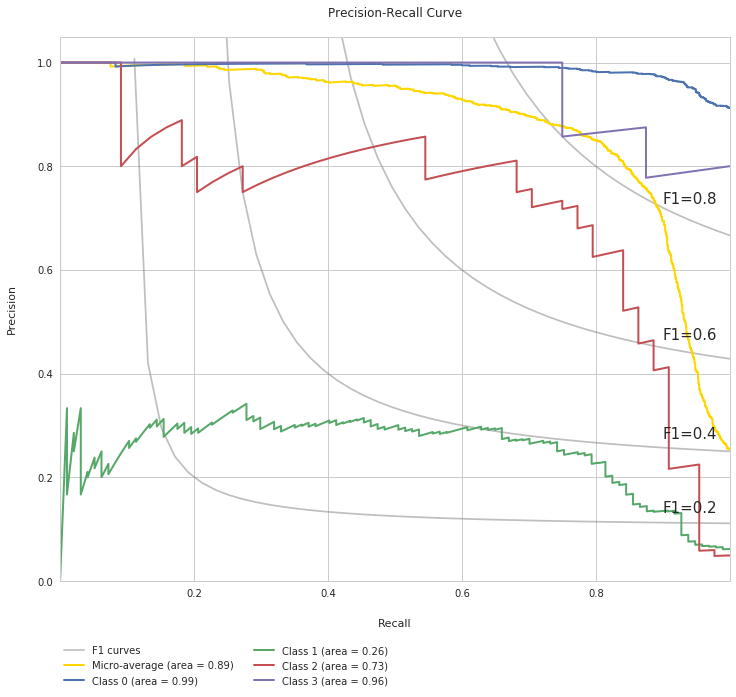

In [142]:
prec_rec_curve(y_test, y_pred_gpc_proba, 4, fontsize=15)

In [135]:
kernel = PairwiseKernel() + DotProduct()
gpc = GaussianProcessClassifier(kernel=kernel, n_jobs=-1)

with joblib.parallel_backend('dask'):
    gpc.fit(X_train_small, y_train_small)

<Figure size 432x288 with 0 Axes>

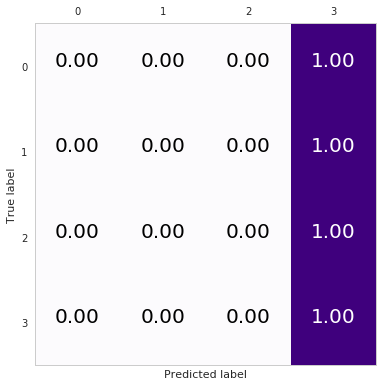

In [136]:
y_pred_gpc_proba = gpc.predict_proba(X_test.values)
y_pred_gpc = np.argmax(y_pred_gpc_proba, axis=1)
plot_confusion_matrix(y_test, y_pred_gpc, range(0,4), normalize=True, cmap=plt.cm.Purples)

### VAE

https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [ ]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


n_params = x_train.shape[1]

# network parameters
input_shape = (n_params, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

# Correct shape?
outputs = Dense(input_shape, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
models = (encoder, decoder)
data = (X_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
#if args.mse:
reconstruction_loss = mse(inputs, outputs)
#else:
#    reconstruction_loss = binary_crossentropy(inputs,
#                                              outputs)

reconstruction_loss *= X_train.shape
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
    
vae.fit(X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, None))

plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")